In [1]:
import pandas as pd

In [2]:
week1 = pd.read_csv("voronoi1.csv")
week2 = pd.read_csv("voronoi2.csv")
week3 = pd.read_csv("voronoi3.csv")
week4 = pd.read_csv("voronoi4.csv")
week5 = pd.read_csv("voronoi5.csv")
week6 = pd.read_csv("voronoi6.csv")
week7 = pd.read_csv("voronoi7.csv")
week9 = pd.read_csv("voronoi9.csv")

In [7]:
dfs = [week1,week2,week3,week4,week5,week6,week7,week9]
final_df = pd.concat(dfs, ignore_index=True)
voronoi_df = final_df[['gameId','playId','routeRunnerId','maxValueOfSeparation']]

In [9]:
df = pd.read_csv("allVoronoi.csv")

In [11]:
df = df.iloc[:,1:]

In [14]:
df = pd.merge(
    df,
    voronoi_df,
    how ="left",
    left_on=['gameId','playId','nflId'],
    right_on = ['gameId','playId','routeRunnerId']
)

In [19]:
df[(df['gameId']==2022090800)&(df['playId']==550)]

,gameId,playId,nflId,motionSinceLineset,inMotionAtBallSnap,wasRunningRoute,wasTargettedReceiver,down,yardsToGo,offenseFormation,...,absoluteYardlineNumber,y,topOfLine,bottomOfLine,position,Unnamed: 0,safetyTop,safetyBottom,routeRunnerId,maxValueOfSeparation
1,2022090800,550,42489,True,True,1.0,0,2,3,SHOTGUN,...,94,38.71,32.51,25.85,WR,1854.0,1.0,1.0,NaN,NaN
100,2022090800,550,44985,False,False,1.0,0,2,3,SHOTGUN,...,94,18.32,32.51,25.85,WR,1854.0,1.0,1.0,NaN,NaN
159,2022090800,550,47879,False,False,1.0,0,2,3,SHOTGUN,...,94,34.35,32.51,25.85,TE,1854.0,1.0,1.0,NaN,NaN
233,2022090800,550,52536,False,False,1.0,0,2,3,SHOTGUN,...,94,11.33,32.51,25.85,WR,1854.0,1.0,1.0,NaN,NaN
706,2022090800,550,47857,False,False,1.0,0,2,3,SHOTGUN,...,94,32.26,32.51,25.85,RB,1854.0,1.0,1.0,NaN,NaN


In [22]:
df = df.dropna()

In [25]:
df.drop(columns=['Unnamed: 0'], inplace=True)

C:\Users\bhaga\AppData\Local\Temp\ipykernel_32248\4136117298.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['Unnamed: 0'], inplace=True)


In [187]:
playerplays = pd.read_csv('player_play.csv')

In [192]:
df = pd.merge(
    df,
    playerplays[['gameId','playId','nflId','routeRan']],
    how = "left",
    on=['gameId','playId','nflId']
)

In [199]:
one = pd.DataFrame(columns=[
    'gameId', 'playId', 'down', 'yardsToGo', 'offenseFormation', 
    'pff_passCoverage', 'absoluteYardlineNumber', 'receiverAlignment',
    'firstY', 'secondY', 'thirdY', 'fourthY', 'fifthY', 'sixthY', 'firstRoute','secondRoute','thirdRoute','fourthRoute','fifthRoute','safetyTop','safetyBottom', 'rbPosition',
    'aboveLine', 'belowLine','motionReceiver', 'motionCluster', 'inMotionAtBallSnap', 
    'targetedReceiver', 'maxSeparationReceiver', 'nflId'
])

for _, i in df.iterrows():
    inone = ((one['gameId'] == i['gameId']) & (one['playId'] == i['playId'])).any()
    
    if not inone:
        play = df[(df['gameId'] == i['gameId']) & 
                       (df['playId'] == i['playId'])]
        play = play.sort_values(by='y', ascending=False)
        motion_players = play[play['motionSinceLineset']]  # Get motion players

        for _, motion_player in motion_players.iterrows():
            thisplay = [
                i['gameId'],
                i['playId'],
                i['down'], 
                i['yardsToGo'], 
                i['offenseFormation'],
                i['pff_passCoverage'], 
                i['absoluteYardlineNumber'],
                i['receiverAlignment']
            ]

            motionrec = 0
            targetrec = 0
            motionindex = 1
            targetindex = 1
            aboveline = 0
            belowline = 0
            moving = False
            rbindex = 0
            maxseparationrec = 0
            max = 0
            for _, j in play.iterrows():
                thisplay.append(j['y'])
                if j['y'] > j['topOfLine']:
                    aboveline += 1
                elif j['y'] < j['bottomOfLine']:
                    belowline += 1
                if j['motionSinceLineset']:
                    if j['nflId'] == motion_player['nflId']:  # Focus on specific motion player
                        motionrec = motionindex
                        if j['inMotionAtBallSnap']:
                            moving = True
                if j['position'] == 'RB':
                    rbindex = targetindex
                if j['wasTargettedReceiver']:
                    targetrec = targetindex
                if j['maxValueOfSeparation'] > max:
                    max = j['maxValueOfSeparation']
                    maxseparationrec = targetindex
                motionindex += 1
                targetindex += 1
            
            

            while len(thisplay) < 14:
                thisplay.append(0)
            
            for _, j in play.iterrows():
                thisplay.append(j['routeRan'])

            while len(thisplay) < 19:
                thisplay.append(0)

            

            thisplay.extend([
                i['safetyTop'],
                i['safetyBottom'],
                rbindex,
                aboveline,
                belowline,
                motionrec,
                0,  # Add motion cluster
                moving,
                targetrec,
                maxseparationrec,  # Find max separation receiver
                motion_player['nflId']
            ])
            
            new_row = pd.DataFrame([thisplay], columns=one.columns)
            one = pd.concat([one, new_row], ignore_index=True)


C:\Users\bhaga\AppData\Local\Temp\ipykernel_32248\586826005.py:89: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  one = pd.concat([one, new_row], ignore_index=True)


In [200]:
one = one[one['thirdY']!=0]

In [201]:
one.iloc[:,8:19]

,firstY,secondY,thirdY,fourthY,fifthY,sixthY,firstRoute,secondRoute,thirdRoute,fourthRoute,fifthRoute
0,43.65,34.37,18.20,8.25,0,0,IN,IN,OUT,GO,0
1,34.99,34.61,26.97,18.19,10.38,0,IN,CROSS,FLAT,GO,GO
2,34.55,25.55,21.53,14.89,0,0,GO,FLAT,GO,IN,0
3,42.03,26.77,26.19,18.16,9.36,0,HITCH,FLAT,ANGLE,GO,HITCH
4,43.64,34.90,26.09,17.15,8.17,0,GO,OUT,FLAT,IN,HITCH
...,...,...,...,...,...,...,...,...,...,...,...
3031,38.03,35.65,30.28,21.88,16.64,0,GO,CROSS,POST,FLAT,CROSS
3032,43.95,35.12,31.33,21.79,9.23,0,POST,CROSS,SLANT,FLAT,GO
3033,33.99,29.91,23.98,21.94,0,0,CORNER,FLAT,CROSS,CROSS,0
3034,42.48,30.85,26.46,16.43,10.69,0,GO,HITCH,ANGLE,HITCH,HITCH


In [196]:
one['maxSeparationReceiver'].value_counts()

maxSeparationReceiver
1    884
5    578
4    516
2    514
3    417
Name: count, dtype: int64

In [116]:
clusters = pd.read_csv("clusters.csv")

In [202]:
one = pd.merge(
    one,
    clusters[['gameId','playId','nflId', 'cluster']],
    how = "left",
    on = ['gameId','playId','nflId']
)

In [203]:
one['motionCluster'] = one['cluster']

Random Forest

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [204]:
X = one.drop(columns = ['gameId','playId','nflId','targetedReceiver','maxSeparationReceiver', 'cluster', 'receiverAlignment', 'sixthY'])

In [205]:
y = one['maxSeparationReceiver']

In [206]:
y = y.astype("category")

In [207]:
X

,down,yardsToGo,offenseFormation,pff_passCoverage,absoluteYardlineNumber,firstY,secondY,thirdY,fourthY,fifthY,...,fourthRoute,fifthRoute,safetyTop,safetyBottom,rbPosition,aboveLine,belowLine,motionReceiver,motionCluster,inMotionAtBallSnap
0,1,10,SHOTGUN,Cover 6-Left,85,43.65,34.37,18.20,8.25,0,...,GO,0,1.0,2.0,0,2,2,1,1.0,False
1,3,4,SHOTGUN,Cover-3,95,34.99,34.61,26.97,18.19,10.38,...,GO,GO,1.0,1.0,3,2,2,1,2.0,True
2,1,10,SHOTGUN,Cover-3,74,34.55,25.55,21.53,14.89,0,...,IN,0,2.0,1.0,0,1,1,3,2.0,True
3,3,2,SHOTGUN,Cover-3,50,42.03,26.77,26.19,18.16,9.36,...,GO,HITCH,0.0,2.0,3,1,2,2,0.0,True
4,1,10,SHOTGUN,Cover-3 Seam,32,43.64,34.90,26.09,17.15,8.17,...,IN,HITCH,1.0,1.0,3,2,2,5,5.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2853,3,6,SHOTGUN,Cover-1,67,38.03,35.65,30.28,21.88,16.64,...,FLAT,CROSS,1.0,1.0,4,3,1,2,1.0,True
2854,4,3,SHOTGUN,Cover-1,85,43.95,35.12,31.33,21.79,9.23,...,FLAT,GO,0.0,2.0,4,3,2,3,6.0,False
2855,3,2,SINGLEBACK,Cover-3,40,33.99,29.91,23.98,21.94,0,...,CROSS,0,1.0,1.0,2,1,2,4,5.0,True
2856,1,10,SHOTGUN,Cover-2,50,42.48,30.85,26.46,16.43,10.69,...,HITCH,HITCH,1.0,1.0,3,2,2,1,1.0,False


In [208]:
X_dummies = pd.get_dummies(X, columns=['down','rbPosition','offenseFormation','motionReceiver','motionCluster', 'pff_passCoverage', 'firstRoute','secondRoute','thirdRoute','fourthRoute','fifthRoute'])

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.2, random_state=42)

In [210]:
y.value_counts()

maxSeparationReceiver
1    858
5    578
4    516
2    489
3    417
Name: count, dtype: int64

In [211]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=30, class_weight="balanced_subsample")

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=30,
                       random_state=42)

In [212]:
print("Accuracy:", accuracy_score(y_train, rf.predict(X_train)))

Accuracy: 1.0


In [213]:
print("Accuracy:", accuracy_score(y_test, rf.predict(X_test)))

Accuracy: 0.5402097902097902


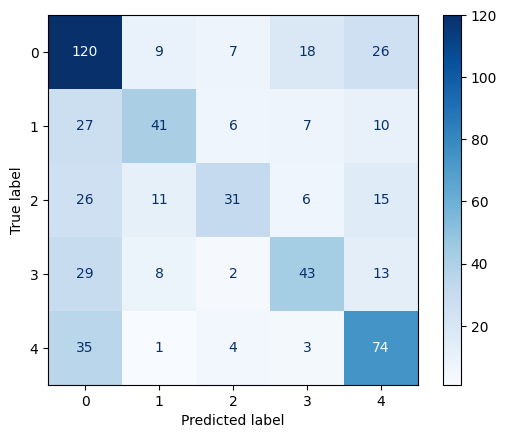

In [214]:
cm_best = confusion_matrix(y_test, rf.predict(X_test))
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best)
disp_best.plot(cmap='Blues')

In [148]:
from imblearn.over_sampling import SMOTE

In [215]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [216]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=30, class_weight="balanced_subsample")

rf.fit(X_resampled, y_resampled)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=30,
                       random_state=42)

In [217]:
print("Accuracy:", accuracy_score(y_train, rf.predict(X_train)))

Accuracy: 1.0


In [218]:
print("Accuracy:", accuracy_score(y_test, rf.predict(X_test)))

Accuracy: 0.5437062937062938


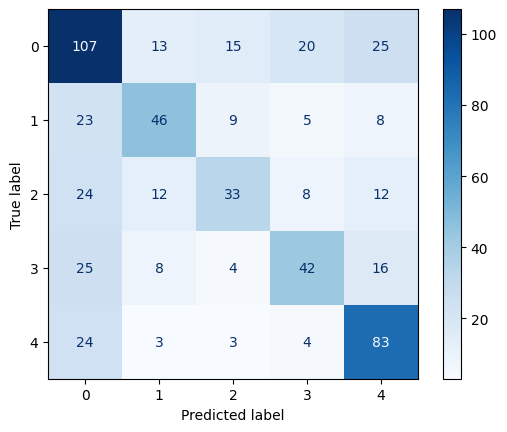

In [219]:
cm_best = confusion_matrix(y_test, rf.predict(X_test))
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best)
disp_best.plot(cmap='Blues')

In [221]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],          # Number of trees in the forest.
    'max_depth': [None, 10, 20, 30],         
    'max_features': ['sqrt', 'log2'],       
    'bootstrap': [True, False]              
}

In [222]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(RandomForestClassifier(), 
                           param_grid=param_grid) 
grid_search.fit(X_resampled, y_resampled) 
print(grid_search.best_estimator_) 

RandomForestClassifier(bootstrap=False, max_features='log2')


In [223]:
rf_model_best = RandomForestClassifier(max_features="log2",
                                    random_state=42,
                                    bootstrap=False) 
rf_model_best.fit(X_resampled, y_resampled) 

RandomForestClassifier(bootstrap=False, max_features='log2', random_state=42)

In [224]:
print("Accuracy:", accuracy_score(y_train, rf_model_best.predict(X_train)))
print("Accuracy:", accuracy_score(y_test, rf_model_best.predict(X_test)))


Accuracy: 1.0
Accuracy: 0.5524475524475524


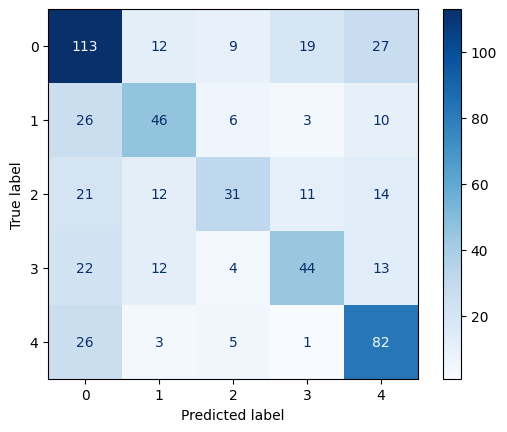

In [225]:
cm_best = confusion_matrix(y_test, rf_model_best.predict(X_test))
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best)
disp_best.plot(cmap='Blues')

In [226]:
feature_importances = rf_model_best.feature_importances_
important = pd.DataFrame()
for name, importance in zip(X_train.columns, feature_importances):
    important = pd.concat([important, pd.DataFrame({'Name': [name], 'Importance': [importance]})], ignore_index=True)

important = important.sort_values(by='Importance', ascending=False)

In [232]:
y_pred = rf_model_best.predict(X_test)
for a,b in zip(y_test,y_pred):
    print(f"True: {a}, Pred: {b}")

True: 1, Pred: 1
True: 4, Pred: 4
True: 5, Pred: 5
True: 1, Pred: 1
True: 1, Pred: 1
True: 1, Pred: 1
True: 5, Pred: 1
True: 1, Pred: 3
True: 2, Pred: 2
True: 2, Pred: 2
True: 1, Pred: 3
True: 1, Pred: 1
True: 1, Pred: 1
True: 4, Pred: 4
True: 2, Pred: 2
True: 4, Pred: 4
True: 3, Pred: 2
True: 5, Pred: 5
True: 2, Pred: 5
True: 1, Pred: 1
True: 2, Pred: 1
True: 3, Pred: 3
True: 2, Pred: 5
True: 1, Pred: 1
True: 4, Pred: 4
True: 2, Pred: 2
True: 1, Pred: 1
True: 1, Pred: 5
True: 4, Pred: 3
True: 1, Pred: 1
True: 2, Pred: 2
True: 1, Pred: 5
True: 3, Pred: 4
True: 5, Pred: 5
True: 1, Pred: 1
True: 1, Pred: 1
True: 1, Pred: 1
True: 2, Pred: 2
True: 2, Pred: 5
True: 3, Pred: 3
True: 5, Pred: 5
True: 4, Pred: 5
True: 3, Pred: 3
True: 1, Pred: 1
True: 3, Pred: 3
True: 3, Pred: 3
True: 2, Pred: 1
True: 5, Pred: 5
True: 1, Pred: 2
True: 4, Pred: 4
True: 5, Pred: 5
True: 5, Pred: 5
True: 1, Pred: 1
True: 3, Pred: 4
True: 5, Pred: 5
True: 1, Pred: 4
True: 5, Pred: 5
True: 4, Pred: 4
True: 4, Pred:

In [252]:
df[['gameId','playId','nflId','y','maxValueOfSeparation']][(df['gameId']==2022091805)&(df['playId']==2207)].sort_values(by='y', ascending=False)

,gameId,playId,nflId,y,maxValueOfSeparation
6075,2022091805,2207,53449,41.28,111.649976
5948,2022091805,2207,43329,32.47,57.682761
5980,2022091805,2207,46071,21.07,62.509320
6230,2022091805,2207,54577,18.68,241.383681
6041,2022091805,2207,48489,11.96,57.897364


In [233]:
y_test.head(10)

1583    1
1745    4
772     5
1728    1
387     1
407     1
2293    5
1991    1
2447    2
2754    2
Name: maxSeparationReceiver, dtype: category
Categories (5, int64): [1, 2, 3, 4, 5]

In [250]:
one.iloc[1745]

gameId                    2022091805
playId                          2207
down                               1
yardsToGo                         10
offenseFormation             SHOTGUN
pff_passCoverage            Quarters
absoluteYardlineNumber            26
receiverAlignment                2x2
firstY                         41.28
secondY                        32.47
thirdY                         21.07
fourthY                        18.68
fifthY                         11.96
sixthY                             0
firstRoute                        GO
secondRoute                       GO
thirdRoute                     WHEEL
fourthRoute                       GO
fifthRoute                     HITCH
safetyTop                        1.0
safetyBottom                     2.0
rbPosition                         3
aboveLine                          2
belowLine                          2
motionReceiver                     2
motionCluster                    NaN
inMotionAtBallSnap             False
t

XGBoost

In [253]:
y = y.cat.codes

In [260]:
X = pd.get_dummies(X, columns=['down','offenseFormation','rbPosition','pff_passCoverage','motionReceiver','motionCluster', 'firstRoute','secondRoute','thirdRoute','fourthRoute','fifthRoute'])

In [263]:
bool_cols = ['yardsToGo', 'absoluteYardlineNumber', 'fifthY', 'aboveLine', 'belowLine', 'inMotionAtBallSnap']  # Add other boolean columns as needed
X[bool_cols] = X[bool_cols].astype(int)

In [264]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [255]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [265]:
class_counts = y_train.value_counts()
scale_pos_weight = class_counts.max() / class_counts.min()

In [266]:
model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=5,
    eval_metric='merror',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    gamma=0, 
    subsample=0.8,
    colsample_bytree=0.8,
    random_state = 42
)

model.fit(X_train, y_train)

c:\Users\bhaga\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:46:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='merror',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

In [267]:
accuracy = accuracy_score(y_train, model.predict(X_train))
print(f"Testing Accuracy: {accuracy:.2f}")

accuracy = accuracy_score(y_test, model.predict(X_test))
print(f"Testing Accuracy: {accuracy:.2f}")

Testing Accuracy: 0.96
Testing Accuracy: 0.51


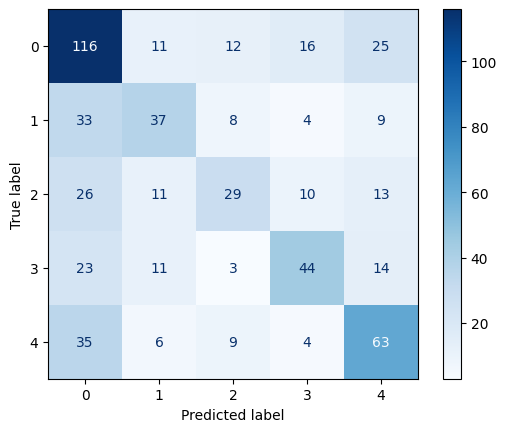

In [268]:
cm_best = confusion_matrix(y_test, model.predict(X_test))
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best)
disp_best.plot(cmap='Blues')

In [269]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [270]:
model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=5,
    eval_metric='merror',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    gamma=0, 
    subsample=0.8,
    colsample_bytree=0.8,
    random_state = 42
)

model.fit(X_resampled, y_resampled)

c:\Users\bhaga\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:50:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='merror',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

In [271]:
accuracy = accuracy_score(y_train, model.predict(X_train))
print(f"Testing Accuracy: {accuracy:.2f}")

accuracy = accuracy_score(y_test, model.predict(X_test))
print(f"Testing Accuracy: {accuracy:.2f}")

Testing Accuracy: 0.93
Testing Accuracy: 0.52
